In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import altair as alt
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd

<h2>Data and Objective</h2>

The data used in this project comes from scikit-learn's dataset and is the fetch_20newsgroups. This data contains approximately 18000 posts from 20 different news groups (these are essentially like the precursor to Reddit threads and were around in the 1980-1990s). The data contains the text of each post and the asociated thread it was posted into. Thus, this data provides us with a natural language processing (NLP) problem, with a particular emphasis on topic modeling. It is my objective to use unsupervised learning algorithms (even though the labels are provided) to create and determine which topics each text applies to. I will utilize nonnegative matrix factorization (NMF), singular value decomposition (SVD) to illuminate the topics and how the posts belong to them. 

In [2]:
#Loading in the data in the train and testing subsets as formed in sklearn
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

<h2>EDA</h2>

As the data was not in a dataframe, my first step was creating training and testing datasets and I also created a y_train/y_test dataset. Further, I created a mapping dataframe which provides each thread and its given numerical value in X_train/X_test data. Next, I checked for null values and did not find any. Then, I ensured there were no duplicate posts. My next step was to create a couple of histograms detailing how many posts were in the data among by topic in both the training and testing set. I utilized altair for this and was surprised to find the distribution of posts by topic to be so similar among training and testing sets.

In [3]:
#Making training and testing X and y dataframes from the data
X_train = pd.DataFrame([train.data, train.target.tolist()]).T
X_train.columns = ['text', 'target']
y_train = pd.DataFrame([train.target.tolist()]).T
y_train.columns = ['target']


X_test = pd.DataFrame([test.data, test.target.tolist()]).T
X_test.columns = ['text', 'target']
y_test = pd.DataFrame([test.target.tolist()]).T
y_test.columns = ['target']

#A Mapping that connects the int label to each category
mapping = pd.DataFrame(train.target_names)
mapping.columns=['label']


In [4]:
#NA
train_null = X_train.isna().sum().sum()
if train_null > 0:
    print(train_null)
test_null = X_test.isna().sum().sum()
if test_null > 0:
    print(test_null)
    

In [5]:
print('Train:')
print(X_train.info())
print('\n')
print('Test:')
X_test.info()

Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   target  11314 non-null  object
dtypes: object(2)
memory usage: 176.9+ KB
None


Test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7532 entries, 0 to 7531
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7532 non-null   object
 1   target  7532 non-null   object
dtypes: object(2)
memory usage: 117.8+ KB


In [25]:
print('Train:')
X_train.describe()

Train:


,text,target
count,11314,11314
unique,11312,20
top,jlleeacsubuffaloedu johnny l lee subject movin...,10
freq,2,600


In [7]:
print('Test:')
X_test.describe()

Test:
                                                     text  target
count                                                7532    7532
unique                                               7532      20
top     From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...      10
freq                                                    1     399




In [8]:
#Plotting Number of Posts by Topic

chart_df = pd.DataFrame(X_train.target.value_counts())
chart_df
topics = [10,15,8,9,11,7,13,5,14,2,12,3,1,6,4,17,16,0,18,19]
data = {'topics': topics, 'counts': chart_df.target}
plot_df = pd.DataFrame(data, columns=['topics', 'counts'])
plot_df

train_hist = alt.Chart(plot_df).mark_bar().encode(
    x='topics:N',
    y='counts',
    tooltip=['topics', 'counts']
).properties(title='Counts of Posts by Topic in Train Set').interactive()
train_hist

alt.Chart(...)

In [9]:
#Plotting Number of Posts by Topic
topics_t = [10, 15, 8, 9, 7, 11, 13, 14, 2, 5, 3, 12, 6, 1, 4, 17, 16, 0, 18, 19]
data = {'topics': topics_t, 'counts': X_test.target.value_counts()}
plot_t_df = pd.DataFrame(data, columns=['topics', 'counts'])
test_hist = alt.Chart(plot_t_df).mark_bar().encode(
    x='topics:N',
    y='counts',
    tooltip=['topics', 'counts']
).properties(title='Counts of Posts by Topic in Test Set').interactive()
test_hist

alt.Chart(...)

<h2>Working with Text Data</h2>

When working with text, there oft needs to be cleaning in order for the models to work with the data. I began this by creating two functions to clean the posts. Firstly, I utilized a function which converts the whole post into lower case and which removes punctuation as determined by the string package. After applying this function to both training and test sets, I utlized my second function to remove stop words. Stop words are those which are quite common in the english value and often provide little signficance to the overall meaning of a text document. An example of these would be 'a', 'these', and 'so'. By removing these, the models can work on words which would have more import to the overall meaning. 

After this, I then utilized the method of topic frequency-inverse document frequency. The mathematics of this is:

    term_frequency(tf) * inverse document frequency(idf),
        tf = # of times word in document / # of terms in document
        idf = log (# of documents / # of documents containing term)
This is method is utilized to measure how important a word is to the overall document it is obtained from. The more times the word appears in a document, the more this importance grows (hence, we can see the importance of removing stopwords). In order to perform this I utilized scikit-learn to fit on the X_train and transform it and then transforming X_test. When this was completed, an entire vocabulary of 138,397 words were used. These methods also produced the data into sparse matrices as the large data may can lead to excessive runtimes.

In [10]:
#Function to convert all text to lowercase and to remove punctuation found in string module's list of punctuation

def lower_remove_punc(text):
    text = text.lower()
    removed = [words for words in text if words not in string.punctuation]
    words_punc_removed = ''.join(removed)
    return words_punc_removed

X_train.text = X_train.text.apply(lambda x: lower_remove_punc(x))
X_test.text = X_test.text.apply(lambda x: lower_remove_punc(x))

#Function ro remove all stopwords that are found in nltk's list of english stopwords

stop_words = set(stopwords.words('english'))
#Removing NLTK stop words
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens_no_stop = [i for i in tokens if i not in stop_words]
    tokens_filtered = (' ').join(tokens_no_stop)
    return tokens_filtered

X_train.text = X_train.text.apply(lambda x: remove_stopwords(x))
X_test.text = X_test.text.apply(lambda x: remove_stopwords(x))


In [11]:
#TFIDF for Train data
vectorizer = TfidfVectorizer(stop_words='english')
vector_tfidf = vectorizer.fit_transform(X_train.text)
print('Vector_tfidf shape:', vector_tfidf.shape)

#TFID for Test data
vector_tfidf_test = vectorizer.transform(X_test.text)
print('Vector_tfidf_test shape:', vector_tfidf_test.shape)

#Vocabulary used
vocabulary = np.array(vectorizer.get_feature_names_out())
print('Amount of Words in Vocab:', vocabulary.shape[0])
print('10 Words from Vocab:', vocabulary[100000:100010])

Vector_tfidf shape: (11314, 138397)
Vector_tfidf_test shape: (7532, 138397)
Amount of Words in Vocab: 138397
10 Words from Vocab: ['packagesx' 'packagesx11r5' 'packaging' 'packard' 'packards' 'packed'
 'packedplanar' 'packedup' 'packer' 'packerdelphigsfcnasagov']


<h2>NMF</h2>

The first unsupervised method I wanted to use was NMF, which I did with scikit-learn. This factorization breaks the initial sparse matrix into W and H matrices which when multiplied together form a matrix very similar to the original data. As I knew the number of topics a priori, I was able to set the number of topics for the factorization.

After completing NMF model and transforming my training and test data, I utlized a function to find the top 10 words for each found topic. From the output, we could see how each topic seems to have words which are highly related in meaning or context indicating NMF was successful. With this large amount of topics, I even found it hard to extract out which topic would belong to which given the top words. Further, I was surprised to find that the same words were found for each topic among both the training and test set. Admittedly, I am not sure as to why this occurred. 

Lastly, in terms of NMF, I outputted the beta-divergence and the weights associated with each component in the model. The beta-divergence is the difference between WH and the intitial data matrix. As NMF does not provided an exact factorization, maintaining a low beta-divergence indicates a well-performing model. In this case, a beta-divergence of 104 was obtained, which is an adequate result given the number of topics. Lastly, I charted the weights associated with each component in the H matrix and in the model. 

In [12]:
#NMF
categories = [val for val in np.unique(y_train)]
num_topics = len(categories)

#Training NMF
model = NMF(n_components=num_topics, init='random', random_state=42)
W = model.fit_transform(vector_tfidf)
H = model.components_

#Testing NMF
W_test = model.transform(vector_tfidf_test)
H_test = model.components_

In [13]:
#Function to show top words by topic
def topics_and_words(H_mat):
    top = lambda x: [vocabulary[i] for i in np.argsort(x)[:-10-1:-1]]
    topic = ([top(x) for x in H_mat])
    return [','.join(x) for x in topic]

#Training top words by topic
print('Top words by topic for training data')
topics_and_words(H)

Top words by topic for training data


['people,gun,dont,think,guns,government,right,like,writes,weapons',
 'space,nasa,moon,launch,shuttle,orbit,lunar,henry,station,henryzootorontoedu',
 'drive,disk,hard,drives,floppy,boot,hd,cable,apple,internal',
 'window,manager,application,motif,expose,server,widget,problem,display,xterm',
 'georgia,michael,covington,athens,programs,706,mcovingtaiugaedu,5420358,306027415,n4tmi',
 'jesus,christian,christians,christ,church,bible,sandviknewtonapplecom,kent,law,jews',
 'scsi,ide,bus,controller,scsi2,scsi1,isa,data,mac,devices',
 'god,believe,gods,bible,faith,truth,hell,existence,belief,exist',
 'car,bike,cars,writes,article,good,like,insurance,dod,engine',
 'morality,keith,objective,moral,schneider,jon,keithccocaltechedu,allan,atheists,livesey',
 'israel,israeli,jews,arab,lebanese,arabs,israelis,peace,lebanon,policy',
 'turkish,armenian,armenians,armenia,serdar,argic,turks,genocide,turkey,serazumauucp',
 'men,homosexual,clayton,cramer,gay,sexual,male,sex,study,partners',
 'windows,file,dos

In [14]:
#Testing top words
print('Top words by topic for testing data')
topics_and_words(H_test)

Top words by topic for testing data


['people,gun,dont,think,guns,government,right,like,writes,weapons',
 'space,nasa,moon,launch,shuttle,orbit,lunar,henry,station,henryzootorontoedu',
 'drive,disk,hard,drives,floppy,boot,hd,cable,apple,internal',
 'window,manager,application,motif,expose,server,widget,problem,display,xterm',
 'georgia,michael,covington,athens,programs,706,mcovingtaiugaedu,5420358,306027415,n4tmi',
 'jesus,christian,christians,christ,church,bible,sandviknewtonapplecom,kent,law,jews',
 'scsi,ide,bus,controller,scsi2,scsi1,isa,data,mac,devices',
 'god,believe,gods,bible,faith,truth,hell,existence,belief,exist',
 'car,bike,cars,writes,article,good,like,insurance,dod,engine',
 'morality,keith,objective,moral,schneider,jon,keithccocaltechedu,allan,atheists,livesey',
 'israel,israeli,jews,arab,lebanese,arabs,israelis,peace,lebanon,policy',
 'turkish,armenian,armenians,armenia,serdar,argic,turks,genocide,turkey,serazumauucp',
 'men,homosexual,clayton,cramer,gay,sexual,male,sex,study,partners',
 'windows,file,dos

In [15]:
# print(mapping)
# [talk.politics.guns, sci.space, comp.sys.mac.hardware, _, _ soc.religion.christian, _, talk.religion.misc, _]
# [alt.atheism, talk.politics.mideast, talk.politics.misc, _, _, sci.crypt, rec.sport.hockey, _, c1omp.graphics]

Beta-divergence: 104.09253379460047


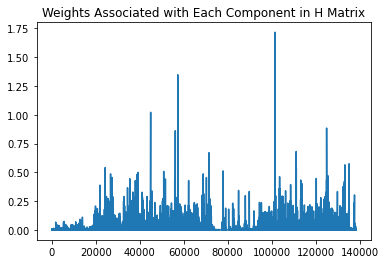

In [16]:
#Beta-divergence and weights by components
plt.plot(model.components_[0])
plt.title(label='Weights Associated with Each Component in H Matrix')
#Beta-divergence is the difference between WH and the intial dataset as WH are not an exact match of the data.
print('Beta-divergence:', model.reconstruction_err_)

<h2>SVD</h2>

After, NMF I wanted to utilize another decomposition method of svd. This method produces an exact decomposition of the intitial data matrix. This results in higher precision among the mathematics; however, it also takes much longer to perform and is much more computationally expensive. Due to this, I utlized a randomized_svd method from scikit-learn. This method has reduced accuracy and precision, but allowed for manageability on my personal computer. Instead of decomposing the entire data matrix, this method randomly utlizes a part of the intitial data matrix, giving its performance changes. 

Further, I decided to not utilize tfidf vectors for this method, but instead utilzied count vectors of the words in the text. This produced the same length of the vocabulary. When the svd was performed, I then utlilized my function to find the top 10 words per topic in the training and testing dataset. It was here I received my biggest surprise of the project, when the top word for our first topic was 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax'. This word surely has high signfiance, but it is also surely a word that was not used often. Thus, we could see the effect of utlizing the count_vector versus the tfidf vector. TFIDF bases importance on the number of times a word appears in a document which may have seen the bizzare word not being found in the top words for topic. In the test set, we did not find any such words which were surprising to me. After this, I then plotted the singular values of each component from svd. These singluar values are a part of the decomposition.

In [17]:
#Vectorizing on basic counts instead of tdidf as svd is much more computationally heavy
count_vec = CountVectorizer(stop_words='english')
vectors_train = count_vec.fit_transform(X_train.text).todense() 
print('Count vector train shape:', vectors_train.shape)

vectors_test = count_vec.transform(X_test.text).todense()
print('Count vector test shape:', vectors_test.shape)

Count vector train shape: (11314, 138397)
Count vector test shape: (7532, 138397)


In [18]:
u, s, v = randomized_svd(vectors_train, 20, random_state = 42, n_iter=2)

In [19]:
#Top words by topic for training data
print('Top 10 words by topics for train data in randomized SVD')
topics_and_words(v)

Top 10 words by topics for train data in randomized SVD


['maxaxaxaxaxaxaxaxaxaxaxaxaxaxax,mg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9v,14,cliff,pwisemansalmonusdedu,maxaxaxaxaxaxaxaxaxaxaxaxaxaxaxq,end,subject,lines,organization',
 'file,use,people,dont,subject,know,like,new,available,information',
 'db,mov,byte,bits,blbh,push,pop,si,di,cx',
 'file,program,jpeg,image,available,entry,use,files,information,output',
 '14,10,16,12,15,13,25,11,20,18',
 'file,mr,stephanopoulos,gun,president,oname,entry,output,going,said',
 'stephanopoulos,mr,president,image,jpeg,available,package,data,going,software',
 'jpeg,image,gif,images,people,format,didnt,dont,said,color',
 'entry,program,oname,wire,wiring,output,char,rules,subject,entries',
 'wire,file,wiring,gun,use,drive,ground,neutral,control,disk',
 'hockey,jpeg,wire,wiring,league,team,nhl,new,season,image',
 'drive,disk,drives,hard,bios,rom,controller,card,feature,scsi',
 'widget,window,available,application,motif,subject,file,set,xt,resource',
 'didnt,said,wire,wiring,went,apartment,anonymous,inter

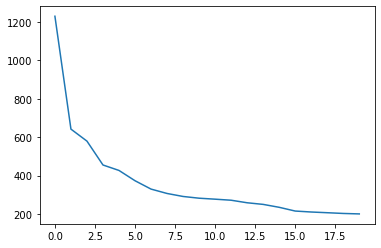

In [26]:
plt.plot(s)

In [20]:
u_test, s_test, v_test = randomized_svd(vectors_test, 20, random_state=42, n_iter=2)

In [21]:
#Top words by topic for testing data
print('Top 10 Words by Topic Among Testing Data')
topics_and_words(v_test)

Top 10 Words by Topic Among Testing Data


['jpeg,image,file,gif,use,images,version,available,files,format',
 'jehovah,god,lord,elohim,said,people,christ,think,father,know',
 'jehovah,jpeg,elohim,lord,god,image,christ,father,gif,mcconkie',
 'graphics,windows,software,dos,mouse,ftp,data,server,disk,network',
 'ms,myers,president,windows,dos,think,mouse,mr,stephanopoulos,mbytes',
 '25,venus,spacecraft,solar,ms,planets,earth,planet,surface,space',
 '25,75,54,cancer,102,33,11,141,19,medical',
 'image,data,myers,president,mr,stephanopoulos,ms,available,package,think',
 'openwindows,use,25,xview,sun,look,myers,file,president,stephanopoulos',
 'adl,bullock,openwindows,gerard,information,cancer,francisco,san,use,police',
 '25,said,armenians,started,went,adl,door,didnt,armenian,children',
 'adl,bullock,25,gerard,subject,lines,organization,writes,san,article',
 'mr,stephanopoulos,general,attorney,president,questions,disk,george,software,question',
 '100,jehovah,appears,art,organization,lines,elohim,300,university,120',
 'files,file,disk,

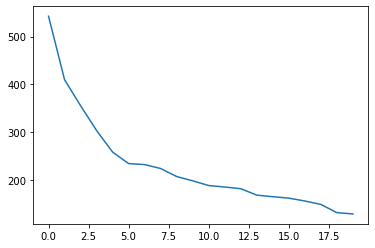

In [27]:
plt.plot(s_test)